# Introduction

In this notebook, I will implement the **k-Means** algorithm from scratch. This is an **unsupervised learning** algorithm used to cluster your data into **k groups**.

**Libraries**

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# How k-means Works?

**k-Means** is an **iterative** clustering algorithm that works as follows:
1. Choose coordinates (e.g. randomly) for the locations of the k centroids.
2. Group datapoints together by finding the nearast centroid. (There will always be k goups).
3. Calculate the new centre of each centroid by taking the mean position of datapoints in each group.
4. Iterate until the centroids stop moving by a significant amount.

<img src="k-means.gif" width="300">

k-Means is popular because it is a **reliable** (always converges) and **relatively fast** algorithm. There are three main drawbacks however:
1. You have to manually choose the **value of k**.
2. The resulting **clusters are spherical**.
3. The resulting **clusters are sensitive** to the random initialisation.

There are methods to help in choosing the value of k, like using a **PCA plot** or the **Elbow Method**  The second point is a limitation of k-Means that **cannot be avoided**. If your data does not naturually fall into circles/spheres then you might be better of with other clustering methods like **GMMs or Bayesian GMMs** 

# Data

I will apply the k-Means algorithm to a **small dataset**.

**Load data**

In [3]:
# Load data
df = pd.read_csv('data.csv')
df.drop('color', axis=1, inplace=True)

# Preview data
print('Dataframe shape:', df.shape)
df.head()

Dataframe shape: (336, 2)


,x,y
0,516.012706,393.014514
1,436.211762,408.656585
2,512.052601,372.022014
3,489.140464,401.807159
4,446.207986,338.516682


**Plot data**

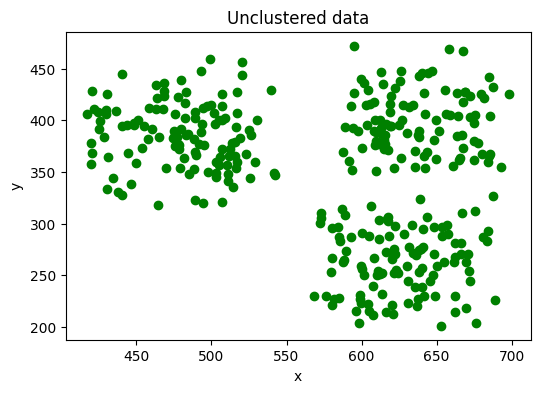

In [16]:
plt.figure(figsize=(6,4))    
plt.scatter(x=data['x'], y=data['y'],color='green') 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Unclustered data')
plt.show()

*Observations:*
    
* There are appear to naturally be 3 clusters to this dataset so we will use k=3 - Note that in Real life example we don't have the ability to see how the data looks like so we will use methods like Elbow or any method to help us to get the opitimal num for k 
* This is an unsupervised learning problem. That is, we don't have any labels to learn from.

# k-Means model

We will implement the model as a **class**. Although more complicated, it allows us to write methods like 'fit' and 'predict', which provides more flexibility.

**The algorithm**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

class KMeans:
    '''K-Means Clustering'''
    
    def __init__(self, k=5, max_iter=100, tol=0.0001):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol

    def euclidean(self, v1, v2):
        return np.linalg.norm(v1 - v2)  # Optimized Euclidean distance

    def fit(self, X_train):
        self.X_train = X_train
        
        # Randomly initialize centroids
        np.random.seed(42)
        idx = np.random.choice(len(X_train), self.k, replace=False)
        self.centroids = X_train[idx, :]
        self.clusters = np.zeros(len(X_train), dtype=int)  # Ensure integer labels
        
        for i in range(self.max_iter):
            prev_centroids = self.centroids.copy()

            # Update clusters
            self.clusters = self._assign_clusters(X_train)

            # Ensure at least 2 unique clusters exist
            unique_clusters = len(np.unique(self.clusters))
            if unique_clusters < 2:
                print(f"Warning: Only {unique_clusters} unique cluster(s) found for k={self.k}. Skipping.")
                return

            # Update centroids
            self.centroids = np.array([X_train[self.clusters == j].mean(axis=0) for j in range(self.k)])

            # Convergence check
            if np.linalg.norm(self.centroids - prev_centroids) < self.tol:
                print(f"Early stopping occurred after {i+1} iterations.")
                break

    def _assign_clusters(self, X):
        # Vectorized computation of Euclidean distance
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)  # Assign to closest centroid

    def predict(self, X_test):
        return self._assign_clusters(X_test)

    def elbow_method(self, X, max_k=10):
        """Find the optimal number of clusters using the Elbow Method."""
        wcss = []  # Stores Within-Cluster Sum of Squares

        for k in range(2, max_k + 1):
            kmeans = KMeans(k=k)
            kmeans.fit(X)

            if hasattr(kmeans, "centroids"):
                # Compute WCSS only if centroids exist
                wcss.append(np.sum(np.min(np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2), axis=1)**2))

        # Plot Elbow Curve
        plt.figure(figsize=(8, 5))
        plt.plot(range(2, len(wcss) + 2), wcss, marker='o', linestyle='--', color='b')
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
        plt.title("Elbow Method")
        plt.show()

    def silhouette_analysis(self, X, max_k=10):
        """Find the optimal number of clusters using the Silhouette Score."""
        silhouette_scores = []  # Stores silhouette scores

        for k in range(2, max_k + 1):  # Start from 2 clusters
            kmeans = KMeans(k=k)
            kmeans.fit(X)
            
            if hasattr(kmeans, "clusters") and len(np.unique(kmeans.clusters)) > 1:
                # Compute Silhouette Score only if multiple clusters exist
                score = silhouette_score(X, kmeans.clusters)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(np.nan)  # Skip invalid cases

        # Convert NaN values to 0 for plotting
        silhouette_scores = np.nan_to_num(silhouette_scores, nan=0)

        # Plot Silhouette Score Curve
        plt.figure(figsize=(8, 5))
        plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--', color='g')
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette Score Analysis")
        plt.show()

        # Best k is where the silhouette score is highest
        if np.nanmax(silhouette_scores) > 0:
            best_k = np.nanargmax(silhouette_scores) + 2  # Since k starts at 2
            print(f"Optimal k based on Silhouette Score: {best_k}")
            return best_k
        else:
            print("No valid k found. Try adjusting the dataset.")
            return None


**Apply our algorithm**

In [39]:
# Apply our k-Means algorithm
model = kMeans(k=3, max_iter=30)
model.fit(data.values)
preds = model.predict(df.values)
preds

Early stopping occured after 2 iterations


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2.

**Plot clusters**

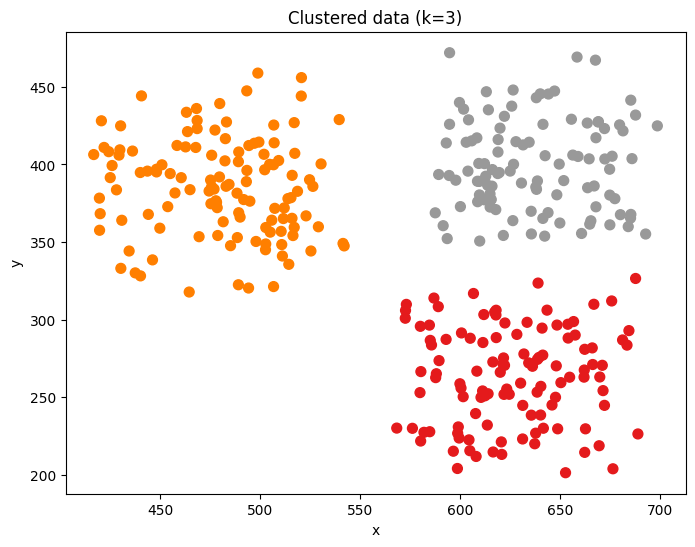

In [40]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(x=data['x'], y=data['y'], c=preds, cmap='Set1', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clustered data (k=3)')
plt.show()

*Observations:*

* kMeans has done a nice job at clustering this practice dataset because we chose the right value of k.

# Experiments

We end by exploring what happens if we choose bad values of k.

**k too small**

Early stopping occured after 7 iterations


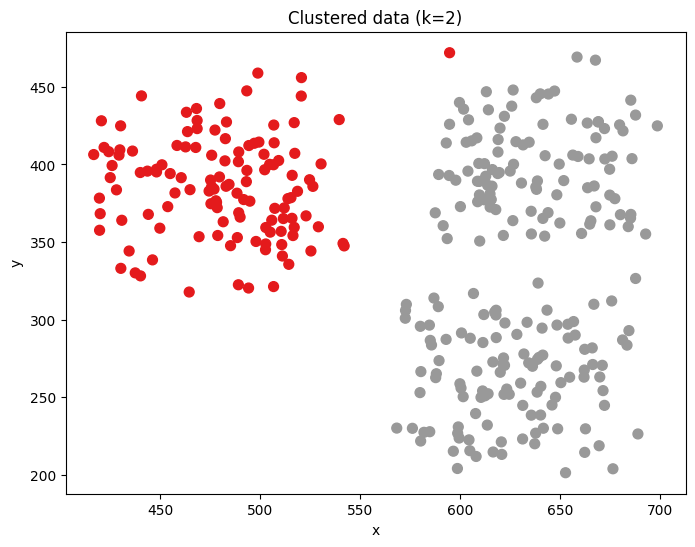

In [41]:
# Apply our k-Means algorithm
model = kMeans(k=2, max_iter=30)
model.fit(data.values)
preds = model.predict(data.values)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(x=data['x'], y=data['y'], c=preds, cmap='Set1', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clustered data (k=2)')
plt.show()

**k too large**

Early stopping occured after 14 iterations


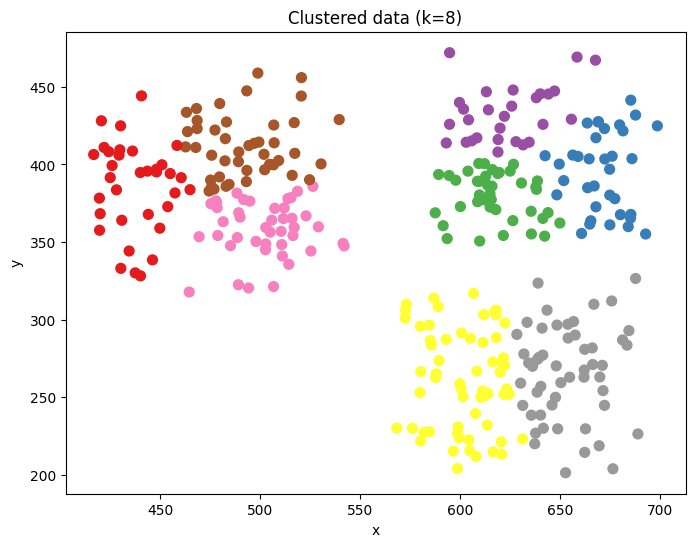

In [42]:
# Apply our k-Means algorithm
model = kMeans(k=8, max_iter=30)
model.fit(data.values)
preds = model.predict(data.values)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(x=data['x'], y=data['y'], c=preds, cmap='Set1', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clustered data (k=8)')
plt.show()

Early stopping occurred after 4 iterations.
Early stopping occurred after 3 iterations.
Early stopping occurred after 7 iterations.
Early stopping occurred after 14 iterations.
Early stopping occurred after 10 iterations.
Early stopping occurred after 7 iterations.


C:\Users\aliay\AppData\Local\Temp\ipykernel_26660\1337217049.py:38: RuntimeWarning: Mean of empty slice.
  self.centroids = np.array([X_train[self.clusters == j].mean(axis=0) for j in range(self.k)])
c:\Users\aliay\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


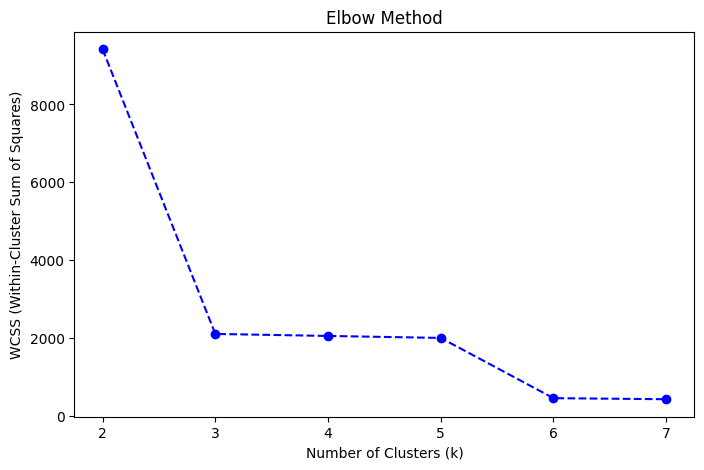

Early stopping occurred after 4 iterations.
Early stopping occurred after 3 iterations.
Early stopping occurred after 7 iterations.
Early stopping occurred after 14 iterations.
Early stopping occurred after 10 iterations.
Early stopping occurred after 7 iterations.


C:\Users\aliay\AppData\Local\Temp\ipykernel_26660\1337217049.py:38: RuntimeWarning: Mean of empty slice.
  self.centroids = np.array([X_train[self.clusters == j].mean(axis=0) for j in range(self.k)])
c:\Users\aliay\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


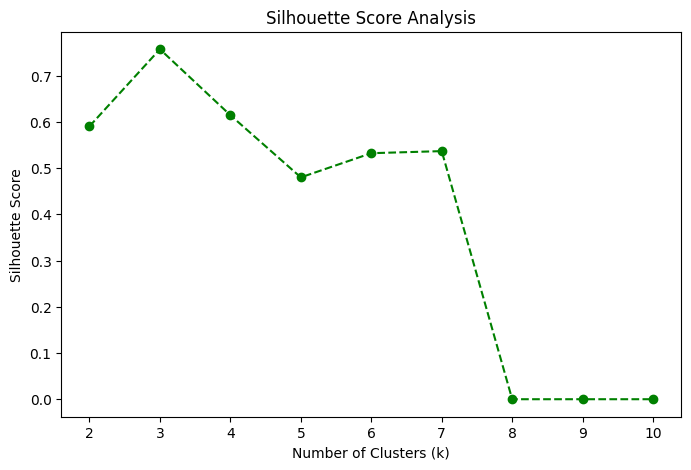

Optimal k based on Silhouette Score: 3
Early stopping occurred after 3 iterations.


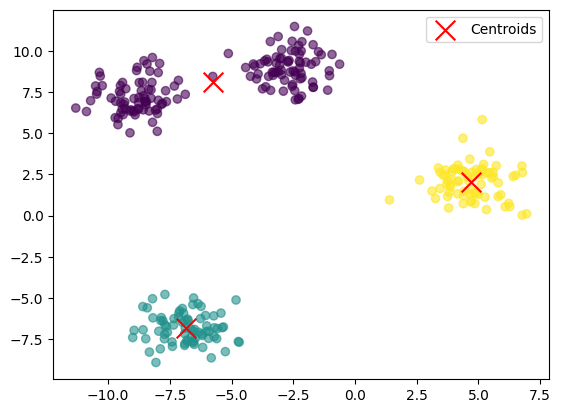

In [43]:
from sklearn.datasets import make_blobs

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=4, random_state=42)

# Initialize KMeans
kmeans = KMeans()

# Find the best k using the Elbow Method
kmeans.elbow_method(X, max_k=10)

# Find the best k using the Silhouette Score
best_k = kmeans.silhouette_analysis(X, max_k=10)

# Train final model with best k
kmeans = KMeans(k=best_k)
kmeans.fit(X)

# Plot final clusters
labels = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200, label="Centroids")
plt.legend()
plt.show()


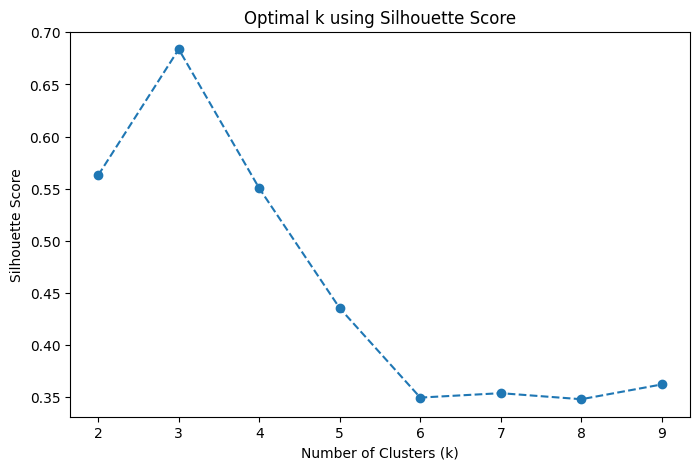

Optimal k based on Silhouette Score: 3


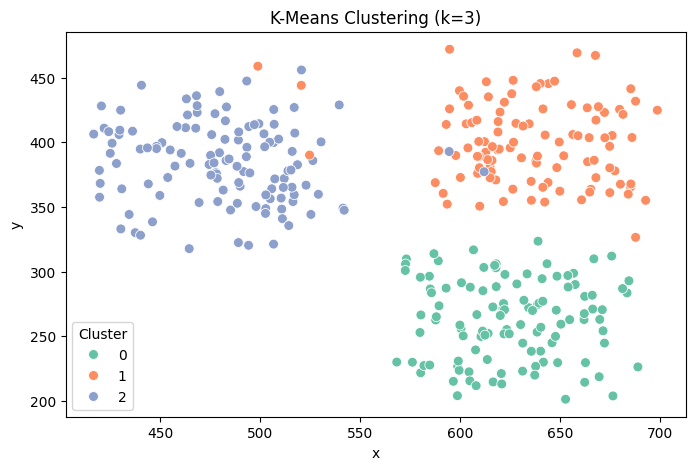

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load Data
df = pd.read_csv("data.csv")  

# Normalize Data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Find Optimal k Using Silhouette Score
silhouette_scores = []
k_values = range(2, 10)  # Testing k from 2 to 10

for k in k_values:
    k_means = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = k_means.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Score vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal k using Silhouette Score")
plt.show()

# Choose Best k (Highest Silhouette Score)
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal k based on Silhouette Score: {optimal_k}")

# Final KMeans Model
kmeans_final = KMeans(n_clusters=optimal_k, init="k-means++", n_init=10, random_state=42)
df["Cluster"] = kmeans_final.fit_predict(df_scaled)

# Scatter Plot of Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["x"], y=df["y"], hue=df["Cluster"], palette="Set2", s=50)
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.legend(title="Cluster")
plt.show()


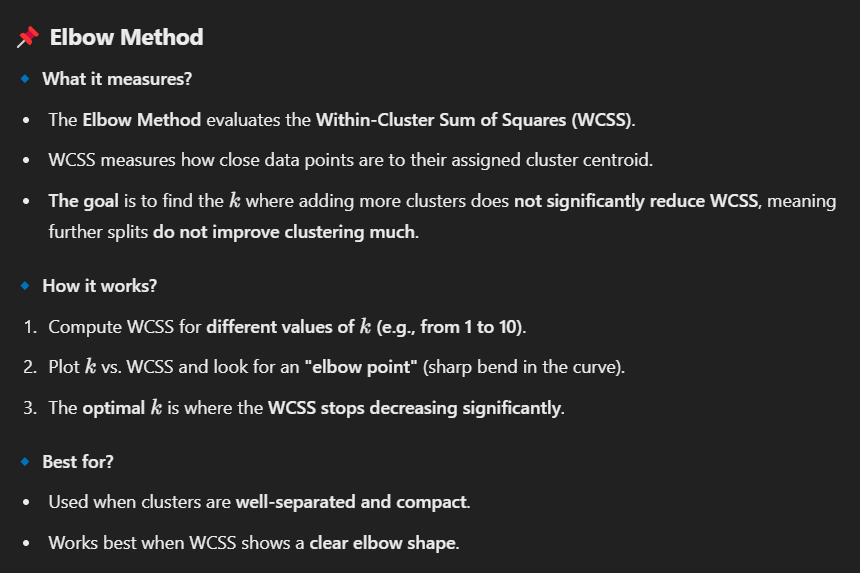 

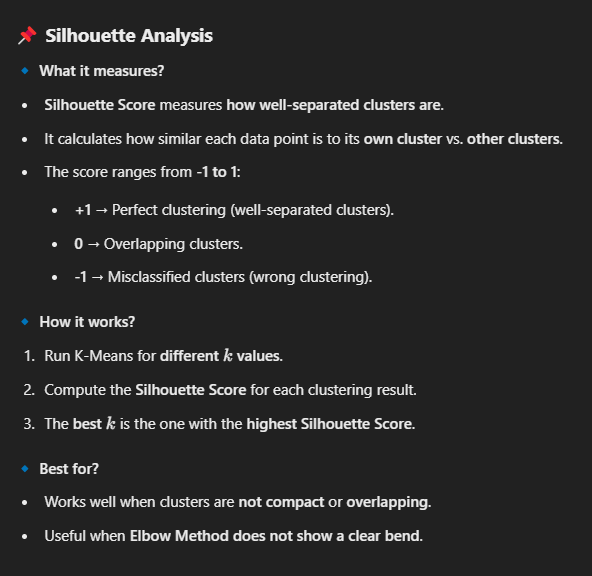